# 취업춘배

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

#한글 폰트
if platform.system()== 'Windows' :
    plt.rc('font', family='NanumGothic')
else:
    plt.rc('font', family = 'AppleGothic')

In [ ]:
driver = webdriver.Chrome('chromedriver.exe')
driver.get("https://job.alio.go.kr/orgcompare.do")
driver.maximize_window()
time.sleep(2) # 창이 켜지는 시간을 감안하여 2초 정도 대기

<ipython-input-3-f019b1ae595d>:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('chromedriver.exe')


In [4]:
# 알리오 372개 공공기관 내부 url 코드 크롤링 (7분 40초 걸림)

codedict = {"institution":[], "code":[]}

for i in range(1, 1370):
    
    if i < 10 :
        urlcode = 'C000{}'.format(i)
    elif 10 <= i | i < 100 :
        urlcode = 'C00{}'.format(i)
    elif 100 <= i | i < 1000 :
        urlcode = 'C0{}'.format(i)
    elif 1000 <= i | i < 10000 :
        urlcode = 'C{}'.format(i)

    url = 'https://alio.go.kr/item/itemReportTerm.do?apbaId={}&reportFormRootNo=20601'.format(urlcode)

    response = requests.get(url)
    response.raise_for_status()

    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
        #print(response.status_code)
    else :
        print(response.status_code)

    institution = soup.select_one('#p_header_wrap > div.hl_area > div > div > span')

    if institution != None:
        codedict['institution'].append(institution.text)
        codedict['code'].append(urlcode)
        print('institution: ' + institution.text + ', code: ' + urlcode)

    i+=1


institution: 88관광개발(주), code: C0001
institution: 가축위생방역지원본부, code: C0002
institution: 강릉원주대학교치과병원, code: C0003


In [ ]:
df = pd.DataFrame(codedict)
df

# 한국광해광업공단(2021.12.08 지정) 이전 데이터 없음 -> 삭제
# **한국율도 데이터 없음 -> 삭제
df.drop(index=226, axis=0, inplace=True)
df.drop(index=371, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

# csv 파일로 저장
df.to_csv('institution_code.csv', index=False)

# 제대로 저장되었는지 확인
institution_code = pd.read_csv('institution_code.csv')
institution_code

In [2]:
institution_code = pd.read_csv('institution_code.csv')
institution_code
institution_code[institution_code['institution']=='**한국율도']

institution_code.drop(index=226, axis=0, inplace=True)
institution_code.drop(index=371, axis=0, inplace=True)
institution_code.reset_index(drop=True, inplace=True)
institution_code

,institution,code
0,88관광개발(주),C0001
1,가축위생방역지원본부,C0002
2,강릉원주대학교치과병원,C0003
3,강원대학교병원,C0004
4,(주)강원랜드,C0005
...,...,...
365,공간정보품질관리원,C1327
366,차세대수치예보모델개발사업단,C1330
367,국립해양과학관,C1333
368,국립호남권생물자원관,C1334


In [145]:
class GetAlioInfo :
    
    def __init__(self, keyword) :
        urlword = institution_code[institution_code['institution']==keyword]['code'].values[0]

        url = 'https://alio.go.kr/item/itemReportTerm.do?apbaId={}&reportFormRootNo=20601'.format(urlword)

        response = requests.get(url)
        response.raise_for_status()

        html = response.text
        self.soup = BeautifulSoup(html, 'html.parser')

        script = self.soup.select("body > script:nth-child(4)")
        str(script[0])
        regex=re.compile("disclosureNo:\"(\d+)\"")
        disclosureNo = regex.findall(str(script[0]))[0]
        disclosureyear = disclosureNo[:4]
        disclosuremonth = disclosureNo[4:6]
        disclosureday = disclosureNo[6:8]

        url = 'https://alio.go.kr/upload/disclosure/{}/{}/{}/{}/doc.html'.format(disclosureyear, disclosuremonth, disclosureday, disclosureNo)

        response = requests.get(url)
        response.raise_for_status()

        if response.status_code == 200:
            html = response.text
            self.soup = BeautifulSoup(html, 'html.parser')
            #print(response.status_code)
        else :
            print(response.status_code)
    
    def get_new_sal(self) :
        address = self.soup.find("a", text="2. 신입사원 초임").findNext(text="합계").parent.parent
        new_sal = address.text.strip().split('\n')
        new_sal[0] = '신입사원 초봉'
        return(new_sal)

    def get_avg_sal(self) :
        address = self.soup.find("td", text="정규직(일반정규직)").findNext(text="1인당 평균 보수액").parent.parent
        avg_sal = address.text.strip().split('\n')
        return(avg_sal)

    def get_y_service(self) :
        address = self.soup.find("td", text="정규직(일반정규직)").findNext(text="평균근속연수(개월)").parent.parent
        y_service = address.text.strip().split('\n')
        return(y_service)


In [58]:
# 확인용 - 삭제할 것
keyword = "강릉원주대학교치과병원"
a = GetAlioInfo(keyword)
a.get_avg_sal()

['1인당 평균 보수액', '40350', '40702', '44002', '43493', '44497', '45365']

In [7]:
avg_sal_dict = {"institution":[], "avg16":[], "avg17":[], "avg18":[], "avg19":[], "avg20":[], "avg21":[]}

i = 0
for keyword in institution_code['institution']:
    a = GetAlioInfo(keyword)
    templist = a.get_avg_sal()
    avg_sal_dict['institution'].append(keyword)
    avg_sal_dict['avg16'].append(templist[1].strip().replace(',',''))
    avg_sal_dict['avg17'].append(templist[2].strip().replace(',',''))
    avg_sal_dict['avg18'].append(templist[3].strip().replace(',',''))
    avg_sal_dict['avg19'].append(templist[4].strip().replace(',',''))
    avg_sal_dict['avg20'].append(templist[5].strip().replace(',',''))
    avg_sal_dict['avg21'].append(templist[6].strip().replace(',',''))
    print(keyword, templist[1:6], sep=',')
    i += 1
    

88관광개발(주),['56,434', '58,444', '61,300', '62,344', '62,676']
가축위생방역지원본부,['59,728', '60,088', '60,792', '66,621', '66,239']
강릉원주대학교치과병원,['40350', '40702', '44002', '43493', '44497']
강원대학교병원,['53,353 ', '56,462 ', '56,812 ', '57,291 ', '55,816 ']
(주)강원랜드,['69,641', '71,281', '72,554', '74,294', '70,676']
건강보험심사평가원,['60,998', '63,280', '63,923', '63,608', '65,538']
경북대학교병원,['62,133', '64,124', '65,399', '65,945', '67,373']
경상국립대학교병원,['61,674', '60,656', '62,494', '61,918', '62,575']
경제인문사회연구회,['59,532', '58,670', '58,671', '59,353', '62,227']
공무원연금공단,['72,354', '71,861', '69,113', '69,821', '70,735']
과학기술정책연구원,['68,435', '71,457', '72,520', '63,271', '68,133']
광주과학기술원,['98,404', '99,155', '101,614', '105,269', '108,266']
한국교통안전공단,['73,533', '72,393', '72,528', '73,904', '75,295']
한국원자력통제기술원,['74,084', '73,480', '78,667', '77,991', '78,568']
국립공원공단,['52,506', '54,464', '55,507', '56,080', '56,859']
국립암센터,['68,947', '70,123', '75,736', '73,457', '75,751']
국민건강보험공단,['61,669', '62,189', '62,2

In [148]:
df = pd.DataFrame(avg_sal_dict)
df.to_csv('alio_avg_sal.csv')

In [140]:
new_sal_dict = {"institution":[], "new16":[], "new17":[], "new18":[], "new19":[], "new20":[], "new21":[]}

i = 0
for keyword in institution_code['institution']:
    a = GetAlioInfo(keyword)
    templist = a.get_new_sal()
    new_sal_dict['institution'].append(keyword)
    new_sal_dict['new16'].append(templist[1].strip().replace(',',''))
    new_sal_dict['new17'].append(templist[2].strip().replace(',',''))
    new_sal_dict['new18'].append(templist[3].strip().replace(',',''))
    new_sal_dict['new19'].append(templist[4].strip().replace(',',''))
    new_sal_dict['new20'].append(templist[5].strip().replace(',',''))
    new_sal_dict['new21'].append(templist[6].strip().replace(',',''))
    print(keyword, templist[1:6], sep=',')
    i += 1
    

88관광개발(주),['25,892', '32,975', '34,678', '35,143', '35,075']
가축위생방역지원본부,['25,544', '26,062', '26,384', '27,241', '27,280']
강릉원주대학교치과병원,['19381', '19790', '20506', '22513', '23160']
강원대학교병원,['26,909 ', '27,900 ', '28,228 ', '28,977 ', '30,094 ']
(주)강원랜드,['37,628', '34,628', '37,765', '38,939', '36,740']
건강보험심사평가원,['34,411', '36,025', '34,693', '35,930', '37,932']
경북대학교병원,['32,239', '33,769', '36,267', '35,321', '35,497']
경상국립대학교병원,['31,523', '33,118', '33,070', '33,860', '34,765']
경제인문사회연구회,['33,458', '34,487', '34,680', '36,680', '37,118']
공무원연금공단,['34,509', '33,097', '33,507', '34,233', '34,023']
과학기술정책연구원,['30,668', '33,832', '34,240', '34,240', '34,488']
광주과학기술원,['37,020', '38,532', '39,872', '41,075', '41,040']
한국교통안전공단,['36,104', '36,913', '37,157', '38,125', '39,986']
한국원자력통제기술원,['41,882', '42,833', '45,115', '46,030', '48,858']
국립공원공단,['29,957', '32,613', '32,563', '34,255', '35,193']
국립암센터,['32,769', '33,816', '37,502', '38,852', '42,042']
국민건강보험공단,['29,803', '30,855', '31,893'

In [143]:
df = pd.DataFrame(new_sal_dict)
df.to_csv('alio_new_sal.csv')
df

In [146]:
y_service_dict = {"institution":[], "ser16":[], "ser17":[], "ser18":[], "ser19":[], "ser20":[], "ser21":[]}

i = 0
for keyword in institution_code['institution']:
    a = GetAlioInfo(keyword)
    templist = a.get_y_service()
    y_service_dict['institution'].append(keyword)
    y_service_dict['ser16'].append(templist[1].strip().replace(',',''))
    y_service_dict['ser17'].append(templist[2].strip().replace(',',''))
    y_service_dict['ser18'].append(templist[3].strip().replace(',',''))
    y_service_dict['ser19'].append(templist[4].strip().replace(',',''))
    y_service_dict['ser20'].append(templist[5].strip().replace(',',''))
    y_service_dict['ser21'].append(templist[6].strip().replace(',',''))
    print(keyword, templist[1:6], sep=',')
    i += 1
    

88관광개발(주),['18', '17.84', '21.40', '19.27', '234']
가축위생방역지원본부,['99', '99', '101', '116', '128']
강릉원주대학교치과병원,['12', '12', '11', '110.88', '111.97']
강원대학교병원,['96 ', '90 ', '83 ', '82 ', '80 ']
(주)강원랜드,['126', '133', '149', '157', '164']
건강보험심사평가원,['137', '133', '131', '122', '127']
경북대학교병원,['147', '153', '141', '152', '138']
경상국립대학교병원,['160', '147', '144', '139', '141']
경제인문사회연구회,['65', '69', '79', '88', '88']
공무원연금공단,['202', '196', '191', '189', '178']
과학기술정책연구원,['133', '145', '141', '102', '105']
광주과학기술원,['125.5', '124.4', '131.5', '141.4', '146']
한국교통안전공단,['188', '187', '180', '171', '168']
한국원자력통제기술원,['88.32', '93.22', '100.60', '103.08', '109.75']
국립공원공단,['145', '147', '155', '148', '143']
국립암센터,['100', '104', '106', '107', '110']
국민건강보험공단,['231', '218', '215', '204', '194']
국민연금공단,['168', '171', '171', '167', '170']
서울올림픽기념국민체육진흥공단,['168', '171', '177', '176', '194']
국제방송교류재단,['152', '163', '165', '169', '179']
국토연구원,['150', '162', '173', '158', '156']
근로복지공단,['171', '163 ', '149 '

In [147]:
df = pd.DataFrame(y_service_dict)
df.to_csv('alio_y_service.csv')

In [137]:
def get_alio_info(keyword):

    urlword = institution_code[institution_code['institution']==keyword]['code'].values[0]

    url = 'https://alio.go.kr/item/itemReportTerm.do?apbaId={}&reportFormRootNo=20601'.format(urlword)

    response = requests.get(url)
    response.raise_for_status()

    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
        #print(response.status_code)
    else :
        print(response.status_code)


    script = soup.select("body > script:nth-child(4)")
    str(script[0])
    regex=re.compile("disclosureNo:\"(\d+)\"")
    disclosureNo = regex.findall(str(script[0]))[0]
    disclosureyear = disclosureNo[:4]
    disclosuremonth = disclosureNo[4:6]
    disclosureday = disclosureNo[6:8]

    url = 'https://alio.go.kr/upload/disclosure/{}/{}/{}/{}/doc.html'.format(disclosureyear, disclosuremonth, disclosureday, disclosureNo)

    response = requests.get(url)
    response.raise_for_status()

    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
        #print(response.status_code)
    else :
        print(response.status_code)

    address = soup.find(text="정규직(일반정규직)").findNext(text="1인당 평균 보수액").parent.parent
    avg_sal = address.text.strip().split('\n')

    address = soup.find("a", text="2. 신입사원 초임").findNext(text="합계").parent.parent
    new_sal = address.text.strip().split('\n')
    new_sal[0] = '신입사원 초봉'

    address = soup.find(text="정규직(일반정규직)").findNext(text="평균근속연수(개월)").parent.parent
    y_service = address.text.strip().split('\n')

    print(keyword)
    # print(avg_sal, new_sal, y_service)

    return avg_sal, y_service, new_sal

In [138]:
get_alio_info('재단법인 한국자활복지개발원')

재단법인 한국자활복지개발원


(['1인당 평균 보수액', '0 ', '0 ', '0 ', '52,034 ', '51,189 ', '51,650'],
 ['평균근속연수(개월)', '0 ', '0 ', '0 ', '5 ', '15 ', '27'],
 ['신입사원 초봉', '0', '0', '0', ' 25,504', '    25,617', '    29,567'])

In [108]:
get_alio_info('한국남동발전(주)')

AttributeError: 'NoneType' object has no attribute 'findNext'

In [16]:
def get_new_sal(keyword):

    urlword = institution_code[institution_code['institution']==keyword]['code'].values[0]

    url = 'https://alio.go.kr/item/itemReportTerm.do?apbaId={}&reportFormRootNo=20601'.format(urlword)

    response = requests.get(url)
    response.raise_for_status()

    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
        #print(response.status_code)
    else :
        print(response.status_code)


    script = soup.select("body > script:nth-child(4)")
    str(script[0])
    regex=re.compile("disclosureNo:\"(\d+)\"")
    disclosureNo = regex.findall(str(script[0]))[0]
    disclosureyear = disclosureNo[:4]
    disclosuremonth = disclosureNo[4:6]
    disclosureday = disclosureNo[6:8]

    url = 'https://alio.go.kr/upload/disclosure/{}/{}/{}/{}/doc.html'.format(disclosureyear, disclosuremonth, disclosureday, disclosureNo)

    response = requests.get(url)
    response.raise_for_status()

    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
        #print(response.status_code)
    else :
        print(response.status_code)

    address = soup.find(text="합계")
    address2 = address.parent
    address3 = address2.parent
    new_sal = address3.text.strip().split('\n')
    new_sal[0] = '신입사원 초봉'

    print(keyword)
    print(new_sal)

    return new_sal

In [35]:
get_alio_info('강릉원주대학교치과병원')

강릉원주대학교치과병원
['1인당 평균 보수액', '40350', '40702', '44002', '43493', '44497', '45365'] ['신입사원 초봉', '19381', '19790', '20506', '22513', '23160', '23494'] ['평균근속연수(개월)', '12', '12', '11', '110.88', '111.97', '123.97']


(['1인당 평균 보수액', '40350', '40702', '44002', '43493', '44497', '45365'],
 ['평균근속연수(개월)', '12', '12', '11', '110.88', '111.97', '123.97'],
 ['신입사원 초봉', '19381', '19790', '20506', '22513', '23160', '23494'])

In [8]:
avg_sal_list = []
new_sal_list = []
y_service_list = []

for keyword in institution_code['institution']:
    get_sal_alio(keyword)
    avg_sal_list.append(avg_sal[1])

88관광개발(주)
['1인당 평균 보수액', '56,434', '58,444', '61,300', '62,344', '62,676', '62,676'] ['신입사원 초봉', '25,892', '32,975', '34,678', '35,143', '35,075', '35,075'] ['평균근속연수(개월)', '18', '17.84', '21.40', '19.27', '234', '234']


NameError: name 'avg_sal' is not defined

'13'

In [ ]:
dictionary = {"institution":[], "title":[], "region":[], "type":[], "start_date":[], "end_date":[], "new_sal":[], "avg_sal":[], "rate":[]}

def current_employment():

    classification = input("""
    직종을 선택해 주세요: 
    1. 경영사무 
    2. 서비스 
    3. ICT 
    4. 교육/연구 
    5. 산업
    6. 전부""")
    if classification == '경영사무':
        classification = '&detail_code=R600001&detail_code=R600002&detail_code=R600003'
    elif classification == '서비스':
        classification = '&detail_code=R600005&detail_code=R600006&detail_code=R600007&detail_code=R600008&detail_code=R600009&detail_code=R600010&detail_code=R600011&detail_code=R600012&detail_code=R600013'
    elif classification == 'ICT':
        classification = '&detail_code=R600019&detail_code=R600020'
    elif classification == '교육/연구':
        classification = '&detail_code=R600004&detail_code=R600025'
    elif classification == '산업':
        classification = '&detail_code=R600014&detail_code=R600015&detail_code=R600016&detail_code=R600017&detail_code=R600018&detail_code=R600021&detail_code=R600022&detail_code=R600023&detail_code=R600024'
    elif classification == '전부':
        classification = ''
    
    page = 1

    while True:

        url = 'https://job.alio.go.kr/recruit.do?pageNo={}&idx=&recruitYear=&recruitMonth={}&work_type=R1010&work_type=R1070&s_date=2021.12.08&e_date=2022.02.08&org_type=&org_name=&ing=2&title=&order=REG_DATE#'.format(page, classification)

        response = requests.get(url)
        response.raise_for_status()

        if response.status_code == 200:
            html = response.text
            soup = BeautifulSoup(html, 'html.parser')
            #print(response.status_code)
        else :
            print(response.status_code)

        tbody = soup.select_one('#frm > table > tbody')
        trs = tbody.select('tr')
        
        if len(tbody.text.strip()) == 0:
            #print('neu~')  # 내용 없는 페이지까지 출력 후 확인용
            break

        for tr in trs:
            tds = tr.select("td")
            dictionary["institution"].append(tds[3].text.replace('재단법인', '(재)').strip())
            dictionary["title"].append(tds[2].text.replace('\t', '').replace('\r', '').replace('\n', '').strip())
            dictionary["region"].append(tds[4].text.replace('\t', '').replace('\r', '').replace('\n', '').strip())
            dictionary["type"].append(tds[5].text.replace('\t', '').replace('\r', '').replace('\n', '').strip())
            dictionary["start_date"].append(tds[6].text)
            dictionary["end_date"].append(tds[7].text)

            # selenium 잡알리오 연봉 정보
            keyword = tds[3].text.strip()
            driver.find_element(By.XPATH, '//*[@id="txt"]/div[1]/form/table/tbody/tr[3]/th/a[2]').click()
            driver.find_element(By.ID, "gi01").send_keys(keyword)
            driver.find_element(By.XPATH, '//*[@id="txt"]/div[1]/form/table/tbody/tr[3]/th/a[1]').click()
            driver.find_element(By.XPATH, '//*[@id="allCheck"]').click()
            driver.find_element(By.XPATH, '//*[@id="txt"]/div[2]/a[1]').click()
            driver.find_element(By.XPATH, '//*[@id="frm"]/div[2]/div[1]/ul/li[3]/a').click()
            print(tds[3].text.strip())
            try:
                new_sal = int(driver.find_element(By.XPATH, '//*[@id="list3_1"]/td[9]').text.replace(',',''))
                dictionary["new_sal"].append(new_sal)
                driver.implicitly_wait(1)
                driver.find_element(By.XPATH, '//*[@id="frm"]/div[2]/div[1]/ul/li[4]/a').click()
                avg_sal = int(driver.find_element(By.XPATH, '//*[@id="list4_1"]/td[9]').text.replace(',',''))
                dictionary["avg_sal"].append(avg_sal)
                print(new_sal, avg_sal)
            except:
                dictionary["new_sal"].append(None)
                dictionary["avg_sal"].append(None)
                print(new_sal, avg_sal)

            # JobPlanet 리뷰
            try:
                keyword = tds[3].text.replace('재단법인', '(재)').strip()
                url = 'https://www.jobplanet.co.kr/search?_rs_act=search_history&_rs_con=seach&category=search_new&query={}'.format(keyword)

                response = requests.get(url)

                response.raise_for_status()
                if response.status_code == 200:
                    html = response.text
                    soup = BeautifulSoup(html, 'html.parser')
                    #print(response.status_code)
                else :
                    print(response.status_code)

                result_card = soup.select_one('#mainContents > div:nth-child(1) > div > div.result_company_card > div.is_company_card > div:nth-child(1)')
                rate = result_card.select_one('#mainContents > div:nth-child(1) > div > div.result_company_card > div.is_company_card > div:nth-child(1) > span.rate_ty02')
                dictionary['rate'].append(float(rate.text.strip()))
                print(rate.text)
            except:
                dictionary['rate'].append(None)
        page += 1

In [ ]:
current_employment()

한국교통연구원
41745 86650
3.3
한국보훈복지의료공단
39262 61964
3.0
주택관리공단(주)
24156 42618
2.4
한국과학영재학교
24156 42618
3.6
코레일네트웍스(주)
32728 46440
2.5
한국보훈복지의료공단
39262 61964
3.0
소상공인시장진흥공단
32460 49941
3.1
국방과학연구소
48222 98070
3.9
한국식품안전관리인증원
36918 52872
3.0
한국등산·트레킹지원센터
36088 49650
4.3
한국보건의료연구원
32537 57548
2.9
아동권리보장원
31086 44821
2.3
한국전기안전공사
38310 63109
2.8
대구경북과학기술원
52637 100769
3.4
한국특허정보원
36945 53908
2.8
한국고용노동교육원
34221 67015
한국산업기술평가관리원
41018 87136
3.9
한국중부발전(주)
42579 86279
4.3
한국서부발전(주)
45381 84890
4.1
한국중부발전(주)
42579 86279
4.3
한국해양수산연수원
27920 66329
2.9
재단법인 한국자활복지개발원
29567 51650
3.0
농업기술실용화재단
33258 63367
3.4
한국보훈복지의료공단
39262 61964
3.0
한국과학기술원
46238 112636
3.5
한국과학기술원
46238 112636
3.5
울산과학기술원
47115 117249
3.3


In [ ]:
df = pd.DataFrame(dictionary)
df

,institution,title,region,type,start_date,end_date,new_sal,avg_sal,rate
0,한국교통연구원,한국교통연구원 2022년 직원 공개채용(1차) 공고,세종,정규직 외 1,2022.02.08,22.02.23,41745.0,86650.0,3.3
1,한국보훈복지의료공단,"[대구보훈병원] 2022년 정규직(임상병리사, 작업치료사, 시설(전기)기능직) 공개채용",대구,정규직,2022.02.08,22.02.17,39262.0,61964.0,3.0
2,주택관리공단(주),채용형 인턴 채용공고(주택관리공단 서울지사),서울 외 1,청년인턴(채용형),2022.02.08,22.02.15,24156.0,42618.0,2.4
3,한국과학영재학교,한국과학기술원 부설 한국과학영재학교 정규직 기술원 채용 공고,부산,정규직,2022.02.07,22.02.21,NaN,NaN,3.6
4,코레일네트웍스(주),코레일네트웍스(주) 2022년 상반기 수시채용,서울 외 2,정규직 외 2,2022.02.04,22.02.18,32728.0,46440.0,2.5
5,한국보훈복지의료공단,[대전보훈병원] 정규직 보건직(의료사회복지사)·기술직(전기)·기능직(행정) 공개채용,대전,정규직,2022.02.04,22.02.14,39262.0,61964.0,3.0
6,소상공인시장진흥공단,2022년 정규직(전산 경력) 채용,대전,정규직,2022.02.04,22.02.21,32460.0,49941.0,3.1
7,국방과학연구소,국방과학연구소 22년 상반기 임용 수시 공개채용,서울 외 5,정규직 외 2,2022.02.04,22.02.18,48222.0,98070.0,3.9
8,한국식품안전관리인증원,2022년도 IT/전산분야 채용 공고,충북,정규직,2022.02.04,22.02.14,36918.0,52872.0,3.0
9,한국등산·트레킹지원센터,2022년 한국등산·트레킹지원센터 정규직(5급) 채용 공고,서울 외 16,정규직,2022.02.04,22.02.18,36088.0,49650.0,4.3


In [ ]:
dfrate = pd.concat([df['institution'], df['rate'], df['new_sal'],df['avg_sal']], axis=1)
dfrate.drop_duplicates(inplace=True)
dfrate.dropna(inplace=True)
dfrate_top5 = dfrate.sort_values(['rate'], ascending=False).head(5)
dfrate_top5

,institution,rate,new_sal,avg_sal
17,한국중부발전(주),4.3,42579.0,86279.0
9,한국등산·트레킹지원센터,4.3,36088.0,49650.0
18,한국서부발전(주),4.1,45381.0,84890.0
7,국방과학연구소,3.9,48222.0,98070.0
16,한국산업기술평가관리원,3.9,41018.0,87136.0


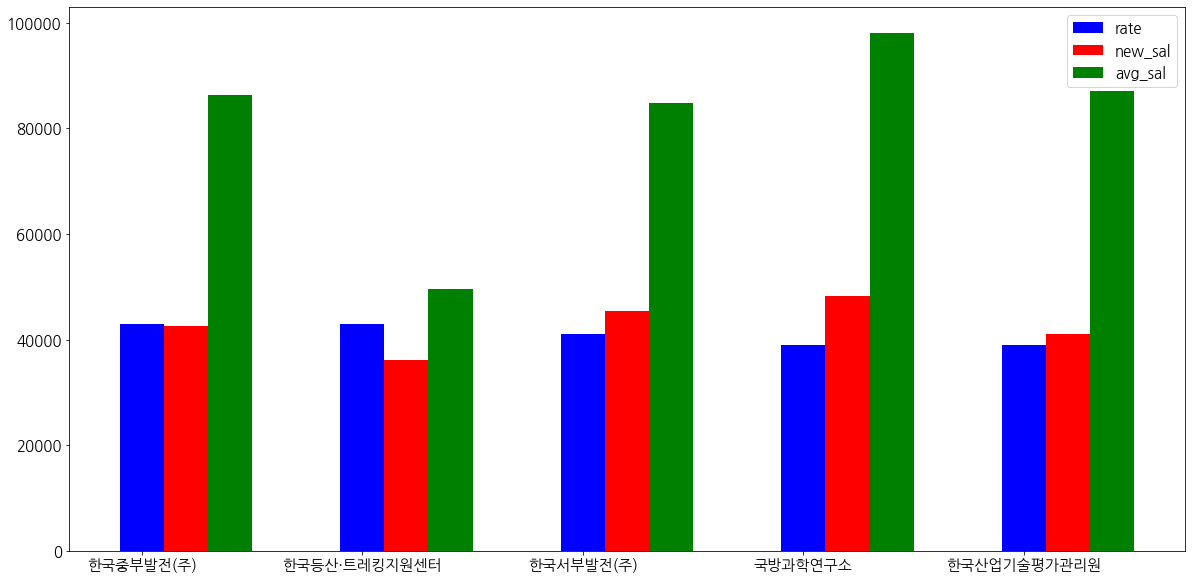

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', size=15)
plt.figure(figsize=(20, 10))

x = np.arange(len(dfrate_top5['institution']))

plt.bar(x-0, dfrate_top5['rate']*10000, label='rate', color = 'b', width=0.2)
plt.bar(x+0.2, dfrate_top5['new_sal'], label='new_sal', color = 'r', width=0.2)
plt.bar(x+0.4, dfrate_top5['avg_sal'], label='avg_sal', color = 'g', width=0.2)
plt.xticks(x, dfrate_top5['institution'])
plt.legend()
plt.show()

In [ ]:
all_dictionary = {"institution":[], "title":[], "region":[], "type":[], "start_date":[], "end_date":[]}

def get_all_employment():

    classification = input("""
    직종을 선택해 주세요:
    1. 경영사무
    2. 서비스
    3. ICT
    4. 교육/연구 """)
    if classification == '경영사무':
        classification = '&detail_code=R600001&detail_code=R600002&detail_code=R600003'
    elif classification == '서비스':
        classification = '&detail_code=R600005&detail_code=R600006&detail_code=R600007&detail_code=R600008&detail_code=R600009&detail_code=R600010&detail_code=R600011&detail_code=R600012&detail_code=R600013'
    elif classification == 'ICT':
        classification = '&detail_code=R600019&detail_code=R600020'
    elif classification == '교육/연구':
        classification = '&detail_code=R600004&detail_code=R600025'
    elif classification == '산업':
        classification = '&detail_code=R600014&detail_code=R600015&detail_code=R600016&detail_code=R600017&detail_code=R600018&detail_code=R600021&detail_code=R600022&detail_code=R600023&detail_code=R600024'
    page = 1

    while True:

        url = 'https://job.alio.go.kr/recruit.do?pageNo={}&idx=&recruitYear=&recruitMonth={}&work_type=R1010&work_type=R1070&s_date=2016.01.01&e_date=2022.02.08&org_type=&org_name=&title=&order=REG_DATE#'.format(page, classification)

        response = requests.get(url)
        response.raise_for_status()

        if response.status_code == 200:
            html = response.text
            soup = BeautifulSoup(html, 'html.parser')
            #print(response.status_code)
        else :
            print(response.status_code)

        tbody = soup.select_one('#frm > table > tbody')
        trs = tbody.select('tr')
        
        if len(tbody.text.strip()) == 0:
            print('neu~')  # 내용 없는 페이지까지 출력 후 확인용
            break

        for tr in trs:
            tds = tr.select("td")
            all_dictionary["institution"].append(tds[3].text.replace('재단법인', '(재)').strip())
            all_dictionary["title"].append(tds[2].text.replace('\t', '').replace('\r', '').replace('\n', '').strip())
            all_dictionary["region"].append(tds[4].text.replace('\t', '').replace('\r', '').replace('\n', '').strip())
            all_dictionary["type"].append(tds[5].text.replace('\t', '').replace('\r', '').replace('\n', '').strip())
            all_dictionary["start_date"].append(tds[6].text)
            all_dictionary["end_date"].append(tds[7].text)

        page += 1


In [ ]:
get_all_employment()

neu~


In [ ]:
df = pd.DataFrame(all_dictionary)
df

,institution,title,region,type,start_date,end_date
0,한국보훈복지의료공단,"[대구보훈병원] 2022년 정규직(임상병리사, 작업치료사, 시설(전기)기능직) 공개채용",대구,정규직,2022.02.08,22.02.17
1,주택관리공단(주),채용형 인턴 채용공고(주택관리공단 서울지사),서울 외 1,청년인턴(채용형),2022.02.08,22.02.15
2,한국과학영재학교,한국과학기술원 부설 한국과학영재학교 정규직 기술원 채용 공고,부산,정규직,2022.02.07,22.02.21
3,코레일네트웍스(주),코레일네트웍스(주) 2022년 상반기 수시채용,서울 외 2,정규직 외 2,2022.02.04,22.02.18
4,한국보훈복지의료공단,[대전보훈병원] 정규직 보건직(의료사회복지사)·기술직(전기)·기능직(행정) 공개채용,대전,정규직,2022.02.04,22.02.14
...,...,...,...,...,...,...
2728,한국로봇산업진흥원,2016년도 한국로봇산업진흥원 신규직원 채용 공고,대구,정규직,2016.01.29,16.02.12
2729,한전원자력연료주식회사,2016년 상반기 NCS기반 직원채용 공고,대전,정규직,2016.01.28,16.02.11
2730,국민연금공단,국민연금공단 응용 프로그래밍 전문가 공개 채용,전북,정규직,2016.01.22,16.01.29
2731,한국사학진흥재단,2016년 상반기 정규직 채용 공고,대구,정규직,2016.01.13,16.01.26


In [ ]:
df['start_date'] = pd.to_datetime(df['start_date'], yearfirst= True)
df['end_date'] = pd.to_datetime(df['end_date'], yearfirst= True)

In [ ]:
df

,institution,title,region,type,start_date,end_date
0,한국보훈복지의료공단,"[대구보훈병원] 2022년 정규직(임상병리사, 작업치료사, 시설(전기)기능직) 공개채용",대구,정규직,2022-02-08,2022-02-17
1,주택관리공단(주),채용형 인턴 채용공고(주택관리공단 서울지사),서울 외 1,청년인턴(채용형),2022-02-08,2022-02-15
2,한국과학영재학교,한국과학기술원 부설 한국과학영재학교 정규직 기술원 채용 공고,부산,정규직,2022-02-07,2022-02-21
3,코레일네트웍스(주),코레일네트웍스(주) 2022년 상반기 수시채용,서울 외 2,정규직 외 2,2022-02-04,2022-02-18
4,한국보훈복지의료공단,[대전보훈병원] 정규직 보건직(의료사회복지사)·기술직(전기)·기능직(행정) 공개채용,대전,정규직,2022-02-04,2022-02-14
...,...,...,...,...,...,...
2728,한국로봇산업진흥원,2016년도 한국로봇산업진흥원 신규직원 채용 공고,대구,정규직,2016-01-29,2016-02-12
2729,한전원자력연료주식회사,2016년 상반기 NCS기반 직원채용 공고,대전,정규직,2016-01-28,2016-02-11
2730,국민연금공단,국민연금공단 응용 프로그래밍 전문가 공개 채용,전북,정규직,2016-01-22,2016-01-29
2731,한국사학진흥재단,2016년 상반기 정규직 채용 공고,대구,정규직,2016-01-13,2016-01-26


In [ ]:
month = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
monthlist = []


for i in range(1, 13):
    monthlist.append(df[df['end_date'].dt.month==i]['institution'].count())

In [ ]:
monthlist

[195, 222, 207, 252, 268, 238, 202, 181, 226, 300, 257, 185]

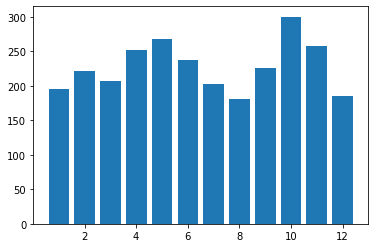

In [ ]:
import matplotlib.pyplot as plt

import pandas as pd



plt.bar(month, monthlist)

plt.show()

